## Static WMS request
Nitrogen mapping example from maps.isric.org


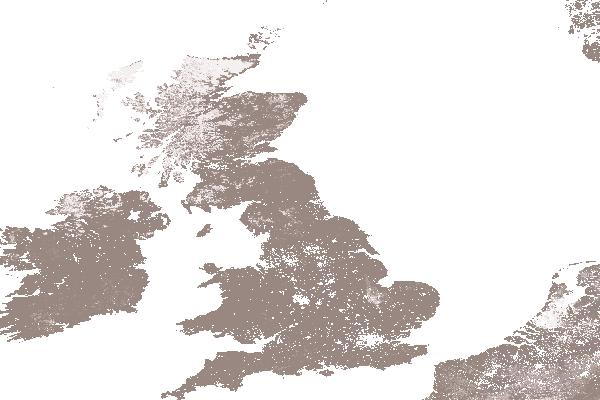

In [1]:
from owslib import wms, wcs
from IPython.display import Image
import folium

base_url = 'https://maps.isric.org/mapserv?map=/map/nitrogen.map'

connection = wms.WebMapService(base_url, version='1.3.0')
r = connection.getmap(
    layers=['nitrogen'],
    size=[600, 400],
    srs="EPSG:4326",
    bbox=[-10, 50.0, 6,60],
    format="image/jpeg")


Image(r.read())

## Folium WMS request

In [2]:
m = folium.Map()
m.add_child(folium.WmsTileLayer(base_url, 'nitrogen'))